<a href="https://colab.research.google.com/github/vtecftwy/utseus-dives/blob/main/nbs/dive_4.2_rag_w_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval Augmented Generation

RAG using Langchain package.

Inspired by LangChain RAG tutorial [here](https://docs.langchain.com/oss/python/langchain/rag)

## 0. Installs, Imports, Utility Fctn and Setup

In [1]:
import faiss
import os
import textwrap
from dotenv import load_dotenv
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from pathlib import Path
from pprint import pprint

In [3]:
def show_attr(o):
    for a in o.__dict__:
        if not '_' in a:
            print(f"{a:10s}: \t{getattr(o, a)}")

def printmd(*txt):
    for t in txt:
        display(Markdown(t))

def setup_clean_proxy():
    """Clear problematic proxy vars and set clean ones"""
    env_backup = {}
    proxy_vars = ['http_proxy', 'https_proxy', 'HTTP_PROXY', 'HTTPS_PROXY', 'no_proxy', 'NO_PROXY']
    for var in proxy_vars:
        if var in os.environ:
            env_backup[var] = os.environ[var]
            del os.environ[var]
    
    os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:16005'
    os.environ['HTTP_PROXY'] = 'http://127.0.0.1:16005'
    return env_backup

# Call at start
env_backup = setup_clean_proxy()

In [4]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

## Step 1: Indexing the knowledge base

1. Load: :Load our data. This is done with Document Loaders. We load all files we want in our knowledge base
2. Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won’t fit in a model’s finite context window.
3. Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

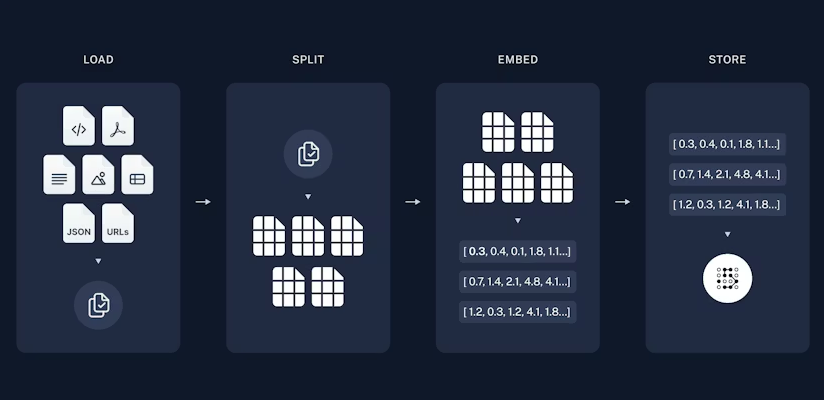

### Loading pdf documents

https://docs.langchain.com/oss/python/integrations/document_loaders/pypdfloader

In [5]:
from langchain_community.document_loaders import PyPDFLoader

In [7]:
p2docs = Path('data')
assert p2docs.is_dir()

In [9]:
files = [f for f in p2docs.iterdir() if f.suffix.lower() == '.pdf']
print('List of files:')
for f in files:
    print(f"- {f.name}")

List of files:
- Brynjolfsson et al. - 2025 - Generative AI at Work.pdf
- Stanford - Tracking Employment Changes in AI-Exposed Jobs.pdf
- McK - One year of agentic ai six lessons from the people doing the work (2025).pdf


Let's load the first file

In [10]:
file_path = files[1]
print(file_path.name)
loader = PyPDFLoader(
    file_path,
    mode="single"
    )

Stanford - Tracking Employment Changes in AI-Exposed Jobs.pdf


The loader will load the split the file in several chunks

In [12]:
docs = loader.load()
len(docs)

1

In [13]:
show_attr(docs[0])

id        : 	None
metadata  : 	{'producer': 'pdfTeX-1.40.22', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-08-01T12:04:28-07:00', 'author': 'Bharat ChandarStanford University; chandarb@stanford.edu. I thank Erik Bynjolfsson, Basil Halperin, Philip Trammell, Luca Vendraminelli, Ruyu Chen, and Tom Mitchell for helpful comments.', 'title': 'Tracking Employment Changes in AI-Exposed Jobs', 'subject': '', 'keywords': '', 'moddate': '2025-08-01T12:04:28-07:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) kpathsea version 6.3.3', 'source': 'data/Stanford - Tracking Employment Changes in AI-Exposed Jobs.pdf', 'total_pages': 23}
type      : 	Document


In [14]:
pprint(docs[0].metadata)

{'author': 'Bharat ChandarStanford University; chandarb@stanford.edu. I thank '
           'Erik Bynjolfsson, Basil Halperin, Philip Trammell, Luca '
           'Vendraminelli, Ruyu Chen, and Tom Mitchell for helpful comments.',
 'creationdate': '2025-08-01T12:04:28-07:00',
 'creator': 'LaTeX with hyperref',
 'keywords': '',
 'moddate': '2025-08-01T12:04:28-07:00',
 'producer': 'pdfTeX-1.40.22',
 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live '
                    '2021) kpathsea version 6.3.3',
 'source': 'data/Stanford - Tracking Employment Changes in AI-Exposed Jobs.pdf',
 'subject': '',
 'title': 'Tracking Employment Changes in AI-Exposed Jobs',
 'total_pages': 23,
 'trapped': '/False'}


In [15]:
print(docs[0].page_content[:2000])

Tracking Employment Changes in AI-Exposed Jobs
Bharat Chandar∗
August 1, 2025
Abstract
This paper examines labor market trends for occupations exposed to Generative AI
using US Current Population Survey (CPS) data from the post-ChatGPT era (Q4 2022
- Q1 2025). Contrary to displacement fears, occupations most exposed to AI on average
show no substantial diﬀerence in employment or earnings growth compared to the
least exposed. However, this aggregate trend masks heterogeneity across occupations.
Within the most exposed quartile, occupations with a higher share of college-educated
workers, such as software development, have experienced robust employment growth,
while those with a lower share, like customer service, have seen declines. The analysis
also reveals a divergence between job posting data and realized employment, urging
caution when inferring labor market trends from postings alone.
1 Introduction
The period following the public release of ChatGPT in November 2022 has seen burgeo

### Splitting document

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split file content into {len(all_splits)} sub-documents.")

Split file content into 41 sub-documents.


In [17]:
for i,s in enumerate(all_splits[:5]):
    print(f'>>> Split {i+1} ------------')
    print(s.page_content)
    print()

>>> Split 1 ------------
Tracking Employment Changes in AI-Exposed Jobs
Bharat Chandar∗
August 1, 2025
Abstract
This paper examines labor market trends for occupations exposed to Generative AI
using US Current Population Survey (CPS) data from the post-ChatGPT era (Q4 2022
- Q1 2025). Contrary to displacement fears, occupations most exposed to AI on average
show no substantial diﬀerence in employment or earnings growth compared to the
least exposed. However, this aggregate trend masks heterogeneity across occupations.
Within the most exposed quartile, occupations with a higher share of college-educated
workers, such as software development, have experienced robust employment growth,
while those with a lower share, like customer service, have seen declines. The analysis
also reveals a divergence between job posting data and realized employment, urging
caution when inferring labor market trends from postings alone.
1 Introduction

>>> Split 2 ------------
also reveals a divergence betwee

### Storing documents

Define an embedding model

In [18]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Define a vector store

In Memory Vector Store

In [19]:
# vector_store = InMemoryVectorStore(embeddings)

FAISS Vector Store

In [20]:
embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [21]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['77b8e5a0-9768-4f73-9c72-73236a6f1821', '4535e11a-5177-4806-beff-cc6fd717ee83', '436d4671-79a1-4dc2-b9d4-273c2f33285b']


In [22]:
print(vector_store.get_by_ids([document_ids[30]])[0].page_content)

Graduates following the Great Recession,” inEducation, Skills, and Technical Change:
Implications for Future US GDP Growth, University of Chicago Press, 149–181. 4
Acemoglu, D., D. Autor, J. Hazell, and P. Restrepo(2022): “ArtiﬁcialIntelligence
and Jobs: Evidence from Online Vacancies,”Journal of Labor Economics, 40, S293–S340,
publisher: The University of Chicago Press. 2, 4
Allen, Mike, J. V. (2025): “Behind the Curtain: Top AI CEO foresees white-collar
bloodbath,” . 1, 4.3
Autor, D. H., F. Levy, and R. J. Murnane(2003): “The Skill Content of Recent
Technological Change: An Empirical Exploration*,”The Quarterly Journal of Economics,
118, 1279–1333. 1
15
Bick, A., A. Blandin, and D. J. Deming(2024): “The Rapid Adoption of Generative
AI,” . 4
Bonney, K., C. Breaux, C. Buffington, E. Dinlersoz, L. Foster, N. Gold-
schlag, J. Haltiwanger, Z. Kroff, and K. Savage(2024): “The impact of AI on
the workforce: Tasks versus jobs?”Economics Letters, 244, 111971. 4


## Step 2: Retrieval

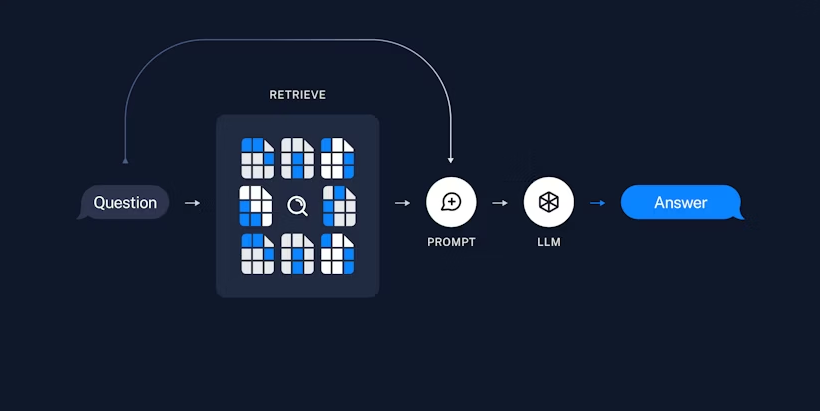

### Similarity Search

Get chunck of text that are similar to a query

In [23]:
sims = vector_store.similarity_search(query='benefit of a genai system in after sales service ', k=4)
len(sims)

4

In [24]:
for i, item in enumerate(sims):
    print(f"--- result #{i+1} ---")
    print("text:")
    wrapped = wrapped = textwrap.fill(item.page_content.replace("\n", " "), width=150)
    print(wrapped)

    print("text length:", len(item.page_content))
    print()

--- result #1 ---
text:
(2025) ﬁnd that access to AI assistance increases worker productivity, as measured by issues resolved per hour, by 15% on average for customer service
representatives, with substan- tial heterogeneity across workers. Figure 2 suggests that employment in customer service representatives has declined
since the release of ChatGPT. These ﬁndings raise the question of which occupational characteristics may inﬂuence the employment eﬀects of AI given
some level of measured exposure. Figure 3 shows employment trends for the most exposed quartile of occupations split by whether the college share in
the occupation is above or below the median. The results suggest employment share increases in more educated exposed occupations and employment share
declines in less educated exposed occupations in the periods before and after the release of ChatGPT. 4.3 Labor Market Trends for Entry-Level Workers
In recent months there has been a growing concern that AI is beginning to displ

In [25]:
sims = vector_store.similarity_search(query='employees reactions to the AI', k=4)
len(sims)

4

In [26]:
for i, item in enumerate(sims):
    print(f"--- result #{i+1} ---")
    print("text:")
    wrapped = wrapped = textwrap.fill(item.page_content.replace("\n", " "), width=150)
    print(wrapped)

    # some useful derived info
    print("text length:", len(item.page_content))
    print()

--- result #1 ---
text:
Eloundou et al. (2024), I examine realized employment and earnings trends to measure whether, and how, disruption from new AI technologies is
appearing in the U.S. workforce. The central ﬁnding is that the most AI-exposed set of occupations has not experienced a declining share of
employment, though among this group there is considerable heterogeneity in labor market trends. Software occupations, which are estimated to have high
exposure to generative AI, show employment gains as of the ﬁrst quarter of 2025. In contrast, customer service representatives, who also have high
measured exposure, have experienced relative employment declines. More broadly, within the most exposed quartile, occupations with a higher share of
college-educated workers have experienced faster employment growth over the prior four years compared to occupations with a lower college share. The
results suggest a nuanced view of how measured AI or automation exposure aﬀect employment, with wo

### Create a tool which perform the retrieval when needed

We will create a tool that will be used by the llm to perform a semantic search of the index before looking for an answer

In [27]:
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    # put all retrieved document into one single string
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [28]:
retrieve_context(query='employees reactions to the AI')

("Source: {'producer': 'pdfTeX-1.40.22', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-08-01T12:04:28-07:00', 'author': 'Bharat ChandarStanford University; chandarb@stanford.edu. I thank Erik Bynjolfsson, Basil Halperin, Philip Trammell, Luca Vendraminelli, Ruyu Chen, and Tom Mitchell for helpful comments.', 'title': 'Tracking Employment Changes in AI-Exposed Jobs', 'subject': '', 'keywords': '', 'moddate': '2025-08-01T12:04:28-07:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) kpathsea version 6.3.3', 'source': 'data/Stanford - Tracking Employment Changes in AI-Exposed Jobs.pdf', 'total_pages': 23, 'start_index': 1536}\nContent: Eloundou et al. (2024), I examine realized employment and earnings trends to measure\nwhether, and how, disruption from new AI technologies is appearing in the U.S. workforce.\nThe central ﬁnding is that the most AI-exposed set of occupations has not experienced a\ndeclining share of emplo

In [29]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    # put all retrieved document into one single string
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

### Create an agent that will use this tool

We create an agent. We will define:
- the model used by the agent (`ChatOpenAI` (abstraction from LangChain))
- the tool available (`retrieve_context`]
- a system prompt

In [30]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, model="gpt-4.1-mini")
tools = [retrieve_context]

system_prompt = (
    "You have access to a tool that retrieves context from a set of files. "
    "Use the tool to help answer user queries."
)

agent = create_agent(model, tools, system_prompt=system_prompt)

Now we can use the agent with specific prompts.

We will visualise all messages from the agent, including all intermediate exchanges.

In [31]:
query = (
    "What are the key findings in this paper"
)

for event in agent.stream(
    input={"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What are the key findings in this paper
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_qGDXKg6Nvag5bw7DDo2cLTf6)
 Call ID: call_qGDXKg6Nvag5bw7DDo2cLTf6
  Args:
    query: key findings
================================= Tool Message =================================
Name: retrieve_context

Source: {'producer': 'pdfTeX-1.40.22', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-08-01T12:04:28-07:00', 'author': 'Bharat ChandarStanford University; chandarb@stanford.edu. I thank Erik Bynjolfsson, Basil Halperin, Philip Trammell, Luca Vendraminelli, Ruyu Chen, and Tom Mitchell for helpful comments.', 'title': 'Tracking Employment Changes in AI-Exposed Jobs', 'subject': '', 'keywords': '', 'moddate': '2025-08-01T12:04:28-07:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) kpat

Let's ask another question about the document.

In [32]:
query = (
    "Wich experiments were done and described in this paper\n\n"
    "Once you have the list of experiments, look up for more information for each experiment"
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Wich experiments were done and described in this paper

Once you have the list of experiments, look up for more information for each experiment
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_zevy6UC0WBRq1OyumgctHeex)
 Call ID: call_zevy6UC0WBRq1OyumgctHeex
  Args:
    query: experiments described in the paper
================================= Tool Message =================================
Name: retrieve_context

Source: {'producer': 'pdfTeX-1.40.22', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-08-01T12:04:28-07:00', 'author': 'Bharat ChandarStanford University; chandarb@stanford.edu. I thank Erik Bynjolfsson, Basil Halperin, Philip Trammell, Luca Vendraminelli, Ruyu Chen, and Tom Mitchell for helpful comments.', 'title': 'Tracking Employment Changes in AI-Exposed Jobs', 'subject': '', 'keywords': '', 'moddate': '2025-08-01T